In [1]:
from torch_geometric.data import Data
import matplotlib as mpl
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
from copy import deepcopy,copy
sys.path.insert(0, "..")

In [2]:
def get_max_xval(graphs):
    max_val = None
    for graph in graphs:
        xs = graph.x
        if max_val is None:
            max_val = torch.max(xs)
        else:
            max_now = torch.max(xs)
            if max_now >= max_val:
                max_val = max_now
    return max_val

def get_min_xval(graphs):
    min_val = None
    for graph in graphs:
        xs = graph.x
        if min_val is None:
            min_val = torch.min(xs)
        else:
            min_now = torch.min(xs)
            if min_now <= min_val:
                min_val = min_now
    return min_val

def get_cmap_colors(graphs, cmap=mpl.cm.brg, Nsteps=10, max_val=None, min_val=None):
    if min_val is None:
        min_val = get_min_xval(graphs=graphs)
    if max_val is None:
        max_val = get_max_xval(graphs=graphs)
    bounds = torch.linspace(min_val, max_val, Nsteps)
    cnorm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cnorm, cmap

In [3]:
def plot(ax, graph, cmap, cnorm, **plot_kwargs):
    with torch.no_grad():
        positions = graph.pos
        edge_indices = graph.edge_index
        cons1 = positions[edge_indices.T[0]]
        cons2 = positions[edge_indices.T[1]]
        ax.set_xlim([torch.min(cons1[:,0])-0.5, torch.max(cons1[:,0])+0.5])
        ax.set_ylim([torch.min(cons1[:,1])-0.5, torch.max(cons1[:,1])+0.5])

        for con1, con2 in zip(cons1, cons2):
            ax.plot([con1[0], con2[0]], [con1[1], con2[1]], c="k")
    
        for i, position, x_val in zip(range(len(positions)), positions, graph.x):
            #print(round(x_val.numpy()[0],1))
            ax.plot(position[0], position[1], "o", markeredgecolor="k", color=cmap(cnorm(x_val)), ms=30, **plot_kwargs)
            ax.annotate(text=f"{round(x_val.numpy()[0],1)}", xy=(position), ha='center', va="center", color="white", fontsize=12)

def get_adj_matrix(graph):
    adj_matrix = to_dense_adj(edge_index=graph.edge_index)
    eigvals, eigmat = torch.linalg.eig(adj_matrix)
    real_eigs = torch.real(eigvals)
    real_eigs, indices = torch.sort(real_eigs, descending=True)
    return adj_matrix, real_eigs[0]

class CustomMessagePassing(MessagePassing):
    def forward(self, x, edge_index):
        return self.propagate(edge_index=edge_index, x=x)

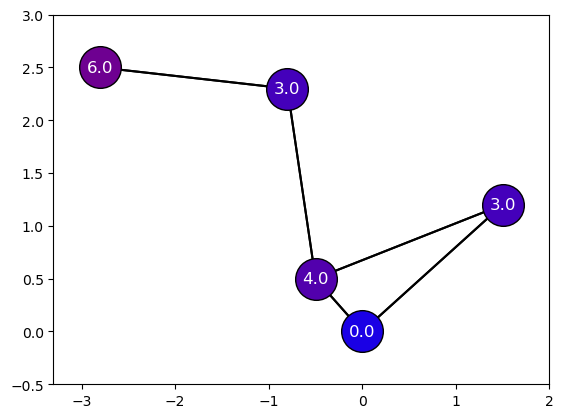

In [4]:
edge_index = torch.tensor([[0,3],
                           [0,4],
                           [1,3],
                           [1,2],
                           [2,1],
                           [3,1],
                           [3,4],
                           [3,0],
                           [4,0],
                           [4,3]], dtype=torch.long)

positions = torch.tensor([[0.0,0.0],
                          [-0.8,2.3],
                          [-2.8, 2.5],
                          [-0.5,0.5],
                          [1.5,1.2]
                          ])
fig, ax = plt.subplots()
x = torch.tensor([0.0, 3.0, 6.0, 4.0, 3.0]).view(-1,1)
message_passer = CustomMessagePassing(aggr="sum")
graph = Data(x=x, edge_index=edge_index, pos=positions)
cnorm, cmap = get_cmap_colors(graphs=[graph], Nsteps=256, cmap=mpl.cm.brg, min_val=-2.0, max_val=35.0)
plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm)

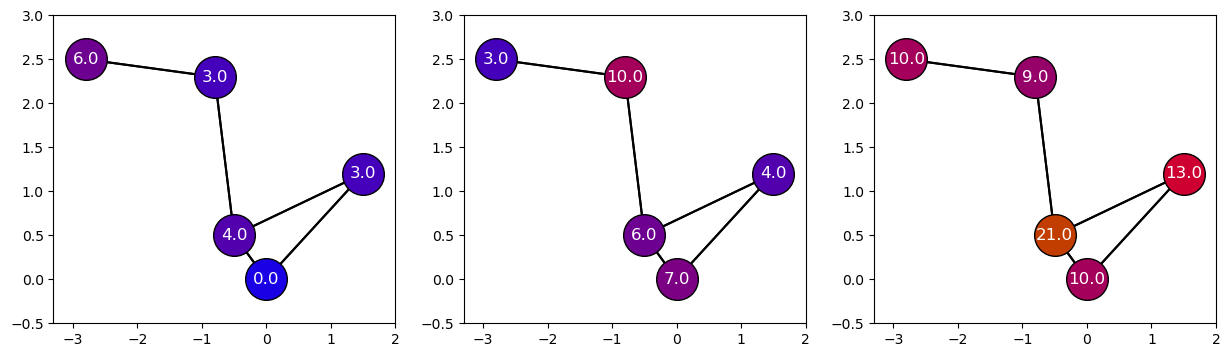

In [5]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
graph = Data(x=x, edge_index=edge_index, pos=positions)
graph_list = []
for i in range(3):
    graph_list.append(copy(graph))
    graph.x = message_passer(graph.x, graph.edge_index.T)
graphs = DataLoader(graph_list)
cnorm, cmap = get_cmap_colors(graphs=[graph], Nsteps=256, cmap=mpl.cm.brg, min_val=-2.0, max_val=35.0)
for ax, graph in zip(axs,graphs):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm)

In [6]:
edge_index = torch.tensor([[0,3],
                           [0,4],
                           [0,0],
                           [1,3],
                           [1,2],
                           [1,1],
                           [2,1],
                           [2,2],
                           [3,1],
                           [3,4],
                           [3,0],
                           [3,3],
                           [4,0],
                           [4,3],
                           [4,4],
                           ], dtype=torch.long)

x = torch.tensor([0.0, 3.0, 6.0, 4.0, 3.0]).view(-1,1)
message_passer = CustomMessagePassing(aggr="sum")

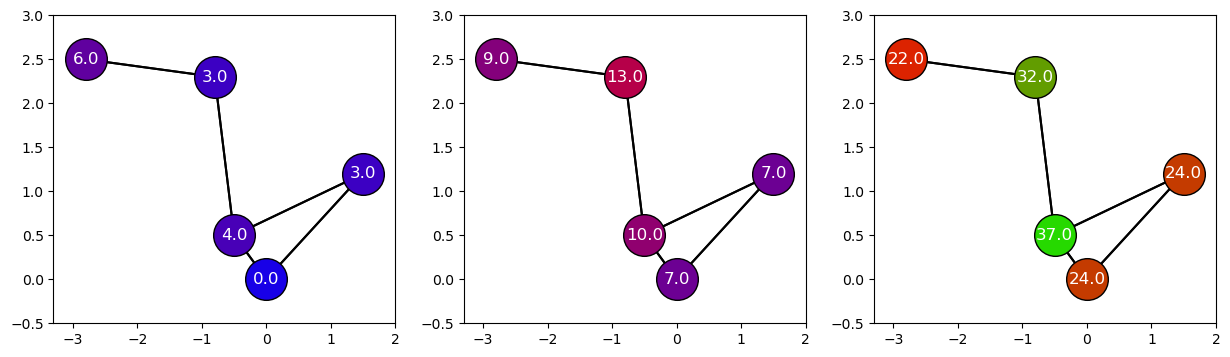

In [7]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
graph = Data(x=x, edge_index=edge_index, pos=positions)
graph_list = []
for i in range(3):
    graph_list.append(copy(graph))
    graph.x = message_passer(graph.x, graph.edge_index.T)
graphs = DataLoader(graph_list)
cnorm, cmap = get_cmap_colors(graphs=[graph], Nsteps=256, cmap=mpl.cm.brg, min_val=-2.0, max_val=40.0)
for ax, graph in zip(axs,graphs):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm)

In [8]:
edge_index = torch.tensor([[0,3],
                           [0,4],
                           [0,0],
                           [1,3],
                           [1,2],
                           [1,1],
                           [2,1],
                           [2,2],
                           [3,1],
                           [3,4],
                           [3,0],
                           [3,3],
                           [4,0],
                           [4,3],
                           [4,4],
                           ], dtype=torch.long)

x = torch.tensor([0.0, 3.0, 6.0, 4.0, 3.0]).view(-1,1)
graph = Data(x=x, edge_index=edge_index)
message_passer = CustomMessagePassing(aggr="max")

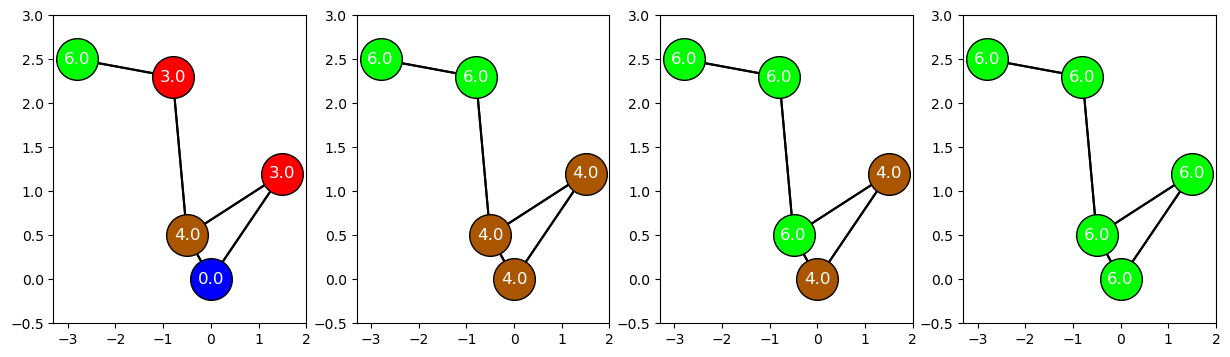

In [9]:
fig, axs = plt.subplots(1,4, figsize=(15,4))
graph = Data(x=x, edge_index=edge_index, pos=positions)
graph_list = []
for i in range(4):
    graph_list.append(copy(graph))
    graph.x = message_passer(graph.x, graph.edge_index.T)
graphs = DataLoader(graph_list)
cnorm, cmap = get_cmap_colors(graphs=graphs, Nsteps=256, cmap=mpl.cm.brg)#, min_val=-2.0, max_val=8.0)
for ax, graph in zip(axs,graphs):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm)

In [12]:
def plot(ax, graph, cmap, cnorm, **plot_kwargs):
    with torch.no_grad():
        positions = graph.pos
        edge_indices = graph.edge_index
        cons1 = positions[edge_indices[0]]
        cons2 = positions[edge_indices[1]]
        ax.set_xlim([torch.min(cons1[:,0])-2.5, torch.max(cons1[:,0])+2.5])
        ax.set_ylim([torch.min(cons1[:,1])-2.5, torch.max(cons1[:,1])+2.5])

        for con1, con2 in zip(cons1, cons2):
            ax.plot([con1[0], con2[0]], [con1[1], con2[1]], c="k")
    
        for i, position, x_val in zip(range(len(positions)), positions, graph.x):
            #print(x_val.numpy())
            ax.plot(position[0], position[1], "o", markeredgecolor="k", color=cmap(cnorm(x_val)), ms=15, **plot_kwargs)
            #ax.annotate(text=f"{round(x_val.numpy(),1)}", xy=(position), ha='center', va="center", color="white", fontsize=12)

def elements_for_random_graph(num_nodes):
    cutoff = 2.5
    box_size=20
    positions = []
    for i in range(num_nodes):
        new_position = torch.rand(1, 2) * box_size
        if len(positions) > 0:
            all_positions = torch.vstack(positions)
            while torch.any(torch.cdist(all_positions, new_position) < 0.75*cutoff) or \
            torch.all(torch.cdist(all_positions, new_position) > cutoff):
                new_position = torch.rand(1, 2) * box_size        
        positions.append(new_position)

    positions = torch.vstack(positions)

    edge_index = []
    for i in range(len(positions)):
        for j in range(len(positions)):
            edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)
    x = torch.tensor(list(range(num_nodes)),dtype=torch.float32)
    return edge_index, positions, x #Returns the edge connections, positions of each node, and then the value of each node

def keep_short_edges(edge_index, positions, r_cut=2.5):
    edge_index_to_keep = []
    for edge in edge_index.T:
        source = positions[edge[0]]
        target = positions[edge[1]]
        if torch.linalg.norm(source-target) <= r_cut:
            edge_index_to_keep.append(edge.numpy())
    #print(edge_index_to_keep)
    return torch.tensor(edge_index_to_keep).T

def random_graph(num_nodes, r_cut=2.5):
    edge_index, positions, x_tensor = elements_for_random_graph(num_nodes=num_nodes)
    edge_index = keep_short_edges(edge_index, positions, r_cut=r_cut)
    graph = Data(x_tensor, edge_index=edge_index, pos=positions)
    return graph

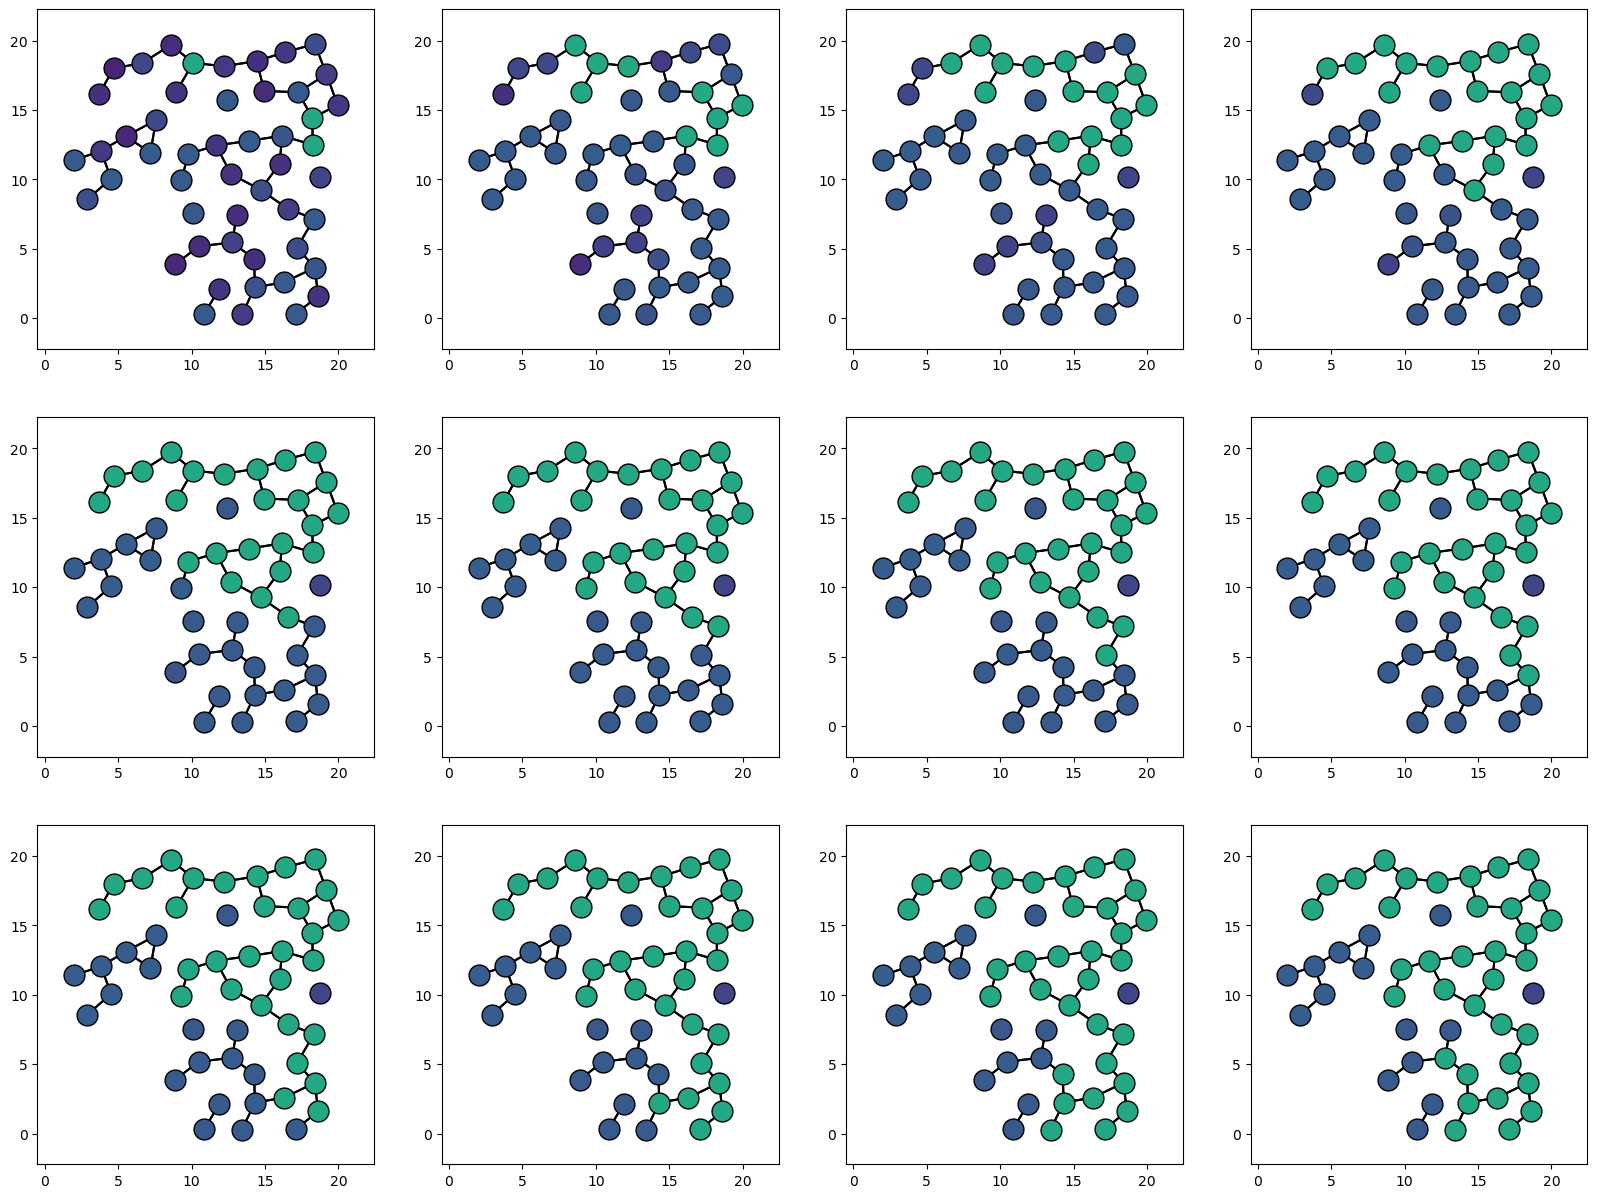

In [13]:
graph = random_graph(50, r_cut=2.4)

fig, axs = plt.subplots(3,4,figsize=(20,15))
graph.x = torch.rand(len(graph.x))-1.0
graph.x[torch.randint(0,len(graph.x), (3,))] = torch.linspace(1.5,1.5,3)
cnorm, cmap = get_cmap_colors(graphs=graphs, Nsteps=256, min_val=-1.5, max_val=3.5, cmap=mpl.cm.viridis)
message_passer = CustomMessagePassing(aggr="max")
graph_list = []

for i in range(12):
    graph_list.append(copy(graph))
    graph.x = message_passer(graph.x.view(-1,1), graph.edge_index)

graphs = DataLoader(graph_list)

for ax, graph in zip(axs.flatten(),graphs):
    plot(ax=ax, graph=graph, cmap=cmap, cnorm=cnorm)
